# Import dependencies

In [7]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import random
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, Dropout
from tensorflow import keras


# Verify if tensorflow is using GPU

In [8]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


# Define image size

In [9]:
image_width = 60
image_height = 60 
image_size = (image_width, image_height)
image_channels = 3
input_shape = (image_width, image_height,image_channels)

# Load data and labels into a dataframe

In [10]:
filenames = os.listdir("./images/train")

categories = []

for filename in filenames:
    category = filename.split('.')[0]
    category = filename.split('(')[0].strip().lower()  # Extract the class name from the filename

    if category == 'tom':
        categories.append(0)
    elif category == 'jerry':
        categories.append(1)
    elif category == 'none':
        categories.append(2)


    else:
        categories.append(3)

df = pd.DataFrame({
    'filename': filenames,
    'class': categories
})
df.head()

,filename,class
0,both (1).jpg,3
1,both (10).jpg,3
2,both (100).jpg,3
3,both (101).jpg,3
4,both (102).jpg,3


# Check counts in each class 

<Axes: xlabel='class'>

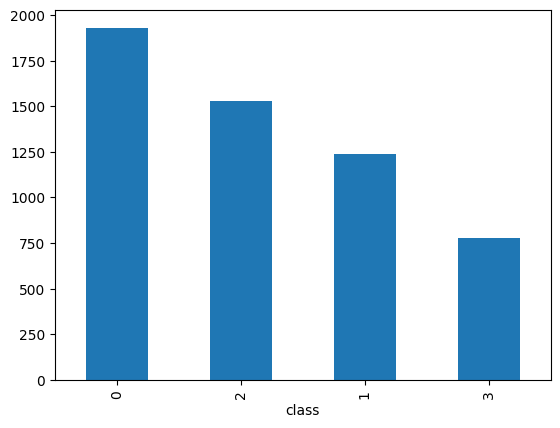

In [11]:
df['class'].value_counts().plot.bar()

# Display 25 random samples

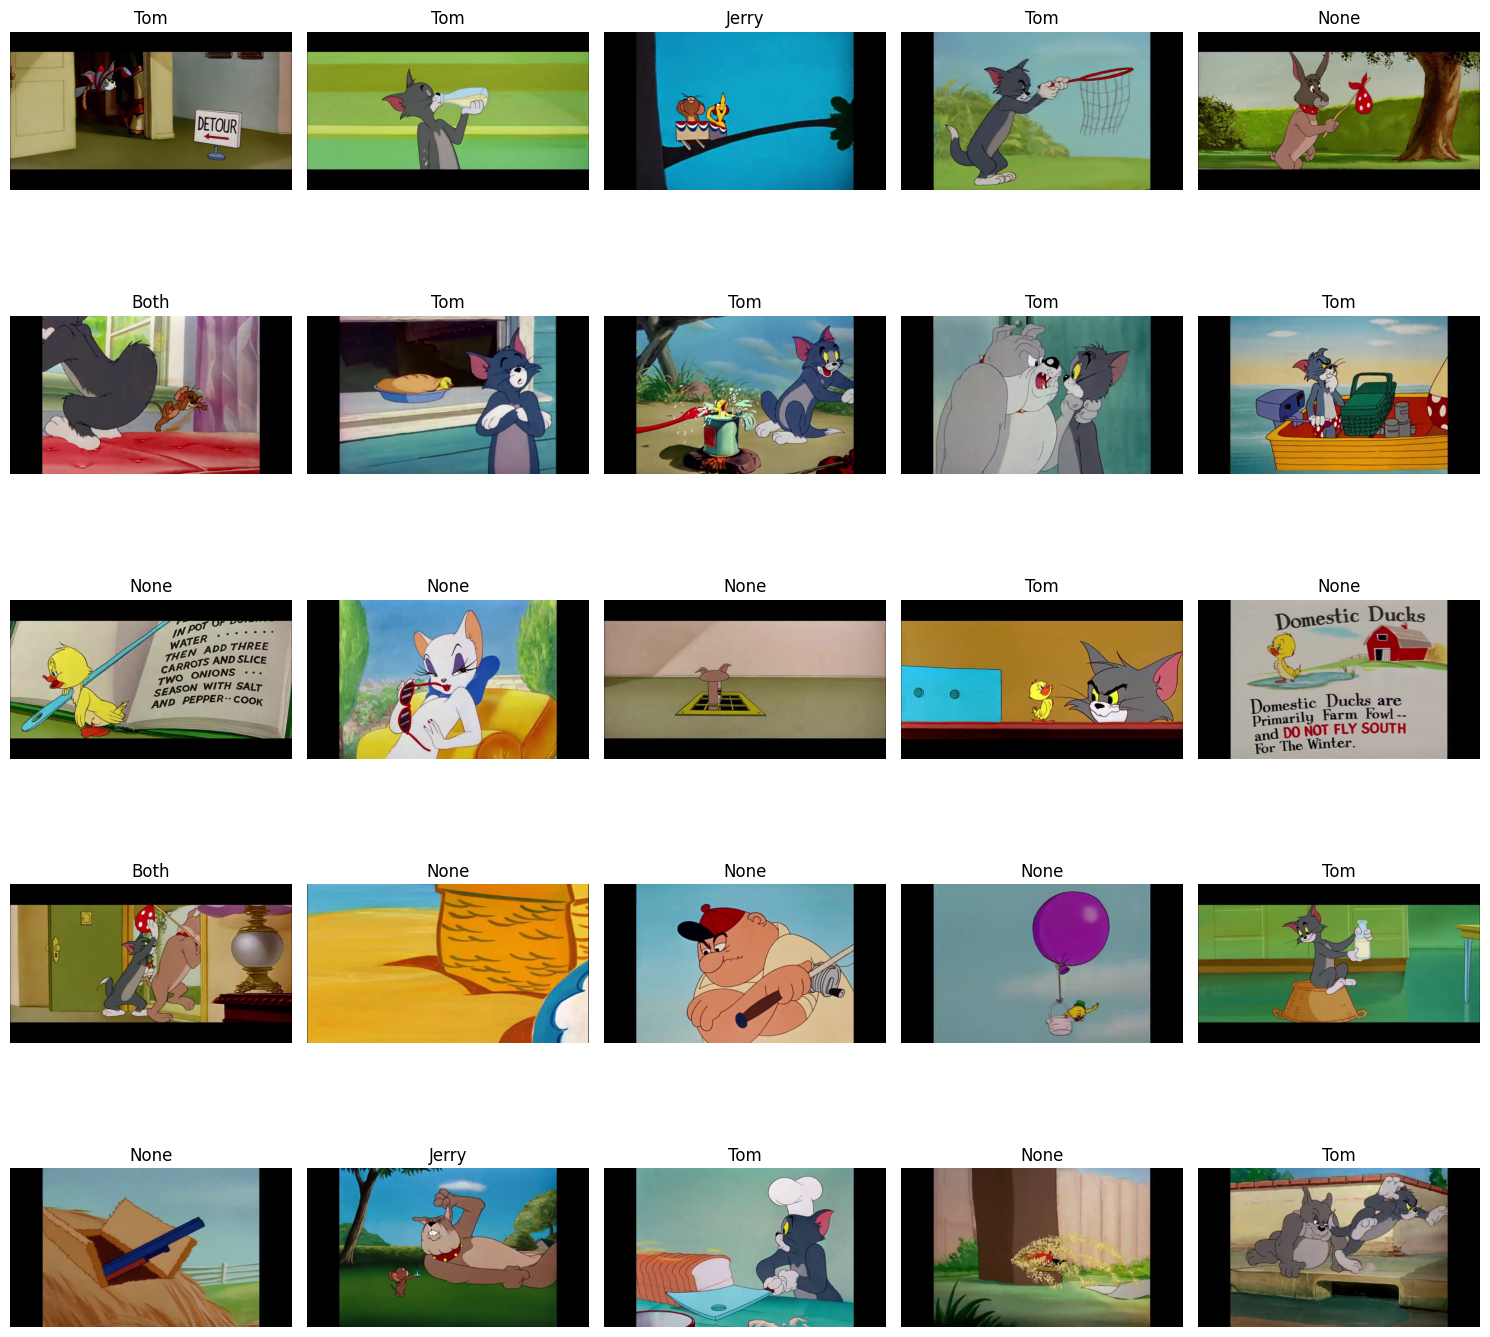

In [12]:
random_samples = random.sample(filenames, 25)

# Define a dictionary to map class labels to class names
class_names = {
    0: 'Tom',
    1: 'Jerry',
    2: 'None',
    3: 'Both'
}

# Display the random images with class labels
plt.figure(figsize=(15, 15))
for i, sample in enumerate(random_samples, 1):
    image = load_img("./images/train/" + sample)
    plt.subplot(5, 5, i)
    plt.imshow(image)
    plt.title(class_names[categories[filenames.index(sample)]])
    plt.axis('off')

plt.tight_layout()
plt.show()


# Create the Inceptionv3 model 

In [14]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (1, 1), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(AveragePooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 58, 58, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 29, 29, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 27, 27, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 13, 13, 64)        4160      
                                                                 
 conv2d_8 (Conv2D)           (None, 11, 11, 128)      

# Compile the model 

In [15]:
opt = keras.optimizers.Adam(learning_rate=0.0005)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


# Replace class numbers with class names

In [16]:
df["class"] = df["class"].replace(class_names)

# Display the updated DataFrame
print(df.head())

         filename class
0    both (1).jpg  Both
1   both (10).jpg  Both
2  both (100).jpg  Both
3  both (101).jpg  Both
4  both (102).jpg  Both


# Split into train and validation

In [17]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=7)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

# Define training data generator

In [18]:
batch_size = 32

train_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "./images/train", 
    x_col = 'filename',
    y_col = 'class',
    target_size = image_size,
    class_mode = 'categorical',
    batch_size = batch_size
)

Found 4382 validated image filenames belonging to 4 classes.


# Define validation data generator

In [19]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "./images/train", 
    x_col='filename',
    y_col='class',
    target_size=image_size,
    class_mode='categorical',
    batch_size=batch_size
)

Found 1096 validated image filenames belonging to 4 classes.


# Load sample batch of generated image 

Found 5 validated image filenames belonging to 3 classes.


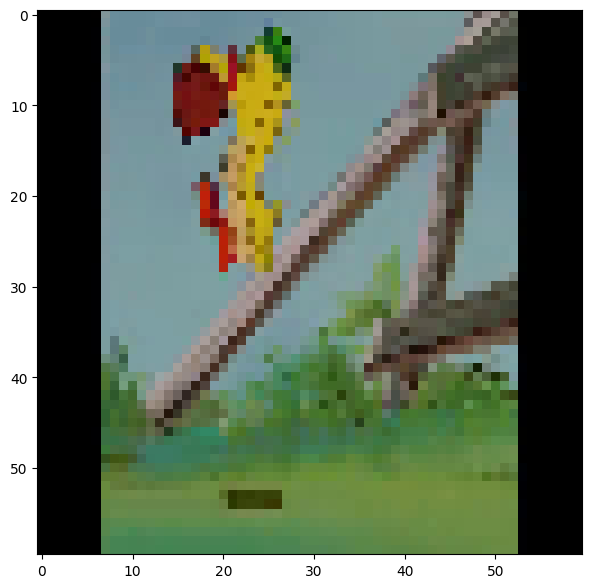

In [20]:
example_df = train_df.sample(n=5).reset_index(drop=True)

example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "./images/train", 
    x_col='filename',
    y_col='class',
    target_size=image_size,
    class_mode='categorical'
)

plt.figure(figsize=(6, 6))

for X_batch, Y_batch in example_generator:
    image = X_batch[1]
    plt.imshow(image)
    break

plt.tight_layout()
plt.show()

# Train the model

In [31]:
epochs = 1000

history = model.fit(
    train_generator, 
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = 256//batch_size,
    steps_per_epoch = 256//batch_size,
)

Epoch 1/1000
8/8 [==============================] - 2s 286ms/step - loss: 0.8189 - accuracy: 0.6445 - val_loss: 0.8446 - val_accuracy: 0.6602
Epoch 2/1000
8/8 [==============================] - 2s 260ms/step - loss: 0.7754 - accuracy: 0.7188 - val_loss: 0.7983 - val_accuracy: 0.6523
Epoch 3/1000
8/8 [==============================] - 2s 259ms/step - loss: 0.8143 - accuracy: 0.6328 - val_loss: 0.7803 - val_accuracy: 0.6641
Epoch 4/1000
8/8 [==============================] - 2s 249ms/step - loss: 0.7233 - accuracy: 0.7148 - val_loss: 0.7726 - val_accuracy: 0.6719
Epoch 5/1000
8/8 [==============================] - 2s 254ms/step - loss: 0.7844 - accuracy: 0.6797 - val_loss: 0.7692 - val_accuracy: 0.6875
Epoch 6/1000
8/8 [==============================] - 2s 252ms/step - loss: 0.8282 - accuracy: 0.6328 - val_loss: 0.8284 - val_accuracy: 0.6641
Epoch 7/1000
8/8 [==============================] - 2s 253ms/step - loss: 0.7774 - accuracy: 0.6680 - val_loss: 0.7279 - val_accuracy: 0.7109
Epoch 

8/8 [==============================] - 2s 235ms/step - loss: 0.3512 - accuracy: 0.8711 - val_loss: 0.4647 - val_accuracy: 0.8242
Epoch 116/1000
8/8 [==============================] - 2s 228ms/step - loss: 0.3075 - accuracy: 0.8867 - val_loss: 0.4690 - val_accuracy: 0.8164
Epoch 117/1000
8/8 [==============================] - 2s 234ms/step - loss: 0.3666 - accuracy: 0.8672 - val_loss: 0.5481 - val_accuracy: 0.8203
Epoch 118/1000
8/8 [==============================] - 2s 226ms/step - loss: 0.3132 - accuracy: 0.8867 - val_loss: 0.7325 - val_accuracy: 0.7578
Epoch 119/1000
8/8 [==============================] - 2s 231ms/step - loss: 0.3376 - accuracy: 0.8945 - val_loss: 0.5590 - val_accuracy: 0.8203
Epoch 120/1000
8/8 [==============================] - 2s 230ms/step - loss: 0.3068 - accuracy: 0.8672 - val_loss: 0.4953 - val_accuracy: 0.8164
Epoch 121/1000
8/8 [==============================] - 2s 231ms/step - loss: 0.3562 - accuracy: 0.8750 - val_loss: 0.6437 - val_accuracy: 0.7812
Epoch 1

Epoch 172/1000
8/8 [==============================] - 2s 224ms/step - loss: 0.2133 - accuracy: 0.9414 - val_loss: 0.7041 - val_accuracy: 0.8008
Epoch 173/1000
8/8 [==============================] - 2s 236ms/step - loss: 0.3163 - accuracy: 0.8828 - val_loss: 0.5375 - val_accuracy: 0.8008
Epoch 174/1000
8/8 [==============================] - 2s 230ms/step - loss: 0.1777 - accuracy: 0.9173 - val_loss: 0.6345 - val_accuracy: 0.7852
Epoch 175/1000
8/8 [==============================] - 2s 232ms/step - loss: 0.2918 - accuracy: 0.8906 - val_loss: 0.4691 - val_accuracy: 0.8281
Epoch 176/1000
8/8 [==============================] - 2s 232ms/step - loss: 0.2250 - accuracy: 0.9102 - val_loss: 0.4937 - val_accuracy: 0.8594
Epoch 177/1000
8/8 [==============================] - 2s 220ms/step - loss: 0.1925 - accuracy: 0.9336 - val_loss: 0.4968 - val_accuracy: 0.8242
Epoch 178/1000
8/8 [==============================] - 2s 238ms/step - loss: 0.2594 - accuracy: 0.8906 - val_loss: 0.6039 - val_accuracy:

Epoch 229/1000
8/8 [==============================] - 2s 238ms/step - loss: 0.1836 - accuracy: 0.9252 - val_loss: 0.6758 - val_accuracy: 0.8281
Epoch 230/1000
8/8 [==============================] - 2s 237ms/step - loss: 0.2011 - accuracy: 0.9219 - val_loss: 0.3804 - val_accuracy: 0.8594
Epoch 231/1000
8/8 [==============================] - 2s 230ms/step - loss: 0.1705 - accuracy: 0.9375 - val_loss: 0.3183 - val_accuracy: 0.8867
Epoch 232/1000
8/8 [==============================] - 2s 243ms/step - loss: 0.2130 - accuracy: 0.9219 - val_loss: 0.6416 - val_accuracy: 0.7891
Epoch 233/1000
8/8 [==============================] - 2s 245ms/step - loss: 0.1336 - accuracy: 0.9648 - val_loss: 0.5141 - val_accuracy: 0.8281
Epoch 234/1000
8/8 [==============================] - 2s 236ms/step - loss: 0.1982 - accuracy: 0.9531 - val_loss: 0.4613 - val_accuracy: 0.8750
Epoch 235/1000
8/8 [==============================] - 2s 246ms/step - loss: 0.1099 - accuracy: 0.9567 - val_loss: 0.5336 - val_accuracy:

Epoch 286/1000
8/8 [==============================] - 2s 274ms/step - loss: 0.1469 - accuracy: 0.9492 - val_loss: 0.3864 - val_accuracy: 0.8828
Epoch 287/1000
8/8 [==============================] - 2s 285ms/step - loss: 0.1020 - accuracy: 0.9609 - val_loss: 0.2980 - val_accuracy: 0.8750
Epoch 288/1000
8/8 [==============================] - 2s 266ms/step - loss: 0.1239 - accuracy: 0.9570 - val_loss: 0.6180 - val_accuracy: 0.8320
Epoch 289/1000
8/8 [==============================] - 2s 271ms/step - loss: 0.0718 - accuracy: 0.9805 - val_loss: 0.5949 - val_accuracy: 0.8477
Epoch 290/1000
8/8 [==============================] - 2s 260ms/step - loss: 0.1689 - accuracy: 0.9492 - val_loss: 0.5365 - val_accuracy: 0.8867
Epoch 291/1000
8/8 [==============================] - 2s 266ms/step - loss: 0.1346 - accuracy: 0.9531 - val_loss: 0.5705 - val_accuracy: 0.8594
Epoch 292/1000
8/8 [==============================] - 2s 319ms/step - loss: 0.0939 - accuracy: 0.9570 - val_loss: 0.4187 - val_accuracy:

Epoch 343/1000
8/8 [==============================] - 2s 241ms/step - loss: 0.0765 - accuracy: 0.9648 - val_loss: 0.6077 - val_accuracy: 0.8516
Epoch 344/1000
8/8 [==============================] - 3s 410ms/step - loss: 0.1273 - accuracy: 0.9414 - val_loss: 0.7522 - val_accuracy: 0.8125
Epoch 345/1000
8/8 [==============================] - 3s 321ms/step - loss: 0.0951 - accuracy: 0.9609 - val_loss: 0.5957 - val_accuracy: 0.8477
Epoch 346/1000
8/8 [==============================] - 2s 298ms/step - loss: 0.1273 - accuracy: 0.9375 - val_loss: 0.4457 - val_accuracy: 0.8594
Epoch 347/1000
8/8 [==============================] - 3s 417ms/step - loss: 0.0961 - accuracy: 0.9570 - val_loss: 0.6104 - val_accuracy: 0.8516
Epoch 348/1000
8/8 [==============================] - 3s 430ms/step - loss: 0.0694 - accuracy: 0.9724 - val_loss: 0.6917 - val_accuracy: 0.8125
Epoch 349/1000
8/8 [==============================] - 2s 252ms/step - loss: 0.1130 - accuracy: 0.9609 - val_loss: 0.5260 - val_accuracy:

Epoch 400/1000
8/8 [==============================] - 2s 242ms/step - loss: 0.0812 - accuracy: 0.9688 - val_loss: 0.5836 - val_accuracy: 0.8828
Epoch 401/1000
8/8 [==============================] - 2s 227ms/step - loss: 0.0771 - accuracy: 0.9648 - val_loss: 0.6170 - val_accuracy: 0.8438
Epoch 402/1000
8/8 [==============================] - 2s 227ms/step - loss: 0.0650 - accuracy: 0.9844 - val_loss: 0.6123 - val_accuracy: 0.8516
Epoch 403/1000
8/8 [==============================] - 2s 234ms/step - loss: 0.0885 - accuracy: 0.9688 - val_loss: 0.8670 - val_accuracy: 0.7930
Epoch 404/1000
8/8 [==============================] - 2s 237ms/step - loss: 0.0950 - accuracy: 0.9609 - val_loss: 1.0572 - val_accuracy: 0.8047
Epoch 405/1000
8/8 [==============================] - 2s 237ms/step - loss: 0.1076 - accuracy: 0.9648 - val_loss: 0.4649 - val_accuracy: 0.8906
Epoch 406/1000
8/8 [==============================] - 2s 233ms/step - loss: 0.0767 - accuracy: 0.9688 - val_loss: 0.4538 - val_accuracy:

Epoch 457/1000
8/8 [==============================] - 2s 235ms/step - loss: 0.2051 - accuracy: 0.9297 - val_loss: 0.7818 - val_accuracy: 0.8203
Epoch 458/1000
8/8 [==============================] - 2s 232ms/step - loss: 0.1295 - accuracy: 0.9492 - val_loss: 0.6693 - val_accuracy: 0.8359
Epoch 459/1000
8/8 [==============================] - 2s 229ms/step - loss: 0.0876 - accuracy: 0.9648 - val_loss: 0.5854 - val_accuracy: 0.8555
Epoch 460/1000
8/8 [==============================] - 2s 230ms/step - loss: 0.0938 - accuracy: 0.9648 - val_loss: 0.7015 - val_accuracy: 0.8320
Epoch 461/1000
8/8 [==============================] - 2s 234ms/step - loss: 0.0773 - accuracy: 0.9688 - val_loss: 0.5192 - val_accuracy: 0.8555
Epoch 462/1000
8/8 [==============================] - 2s 231ms/step - loss: 0.0937 - accuracy: 0.9648 - val_loss: 0.5173 - val_accuracy: 0.8477
Epoch 463/1000
8/8 [==============================] - 2s 243ms/step - loss: 0.0876 - accuracy: 0.9766 - val_loss: 0.7089 - val_accuracy:

Epoch 514/1000
8/8 [==============================] - 2s 224ms/step - loss: 0.0855 - accuracy: 0.9648 - val_loss: 0.7373 - val_accuracy: 0.8320
Epoch 515/1000
8/8 [==============================] - 2s 231ms/step - loss: 0.0777 - accuracy: 0.9648 - val_loss: 0.5679 - val_accuracy: 0.8359
Epoch 516/1000
8/8 [==============================] - 2s 227ms/step - loss: 0.0590 - accuracy: 0.9727 - val_loss: 0.9404 - val_accuracy: 0.7852
Epoch 517/1000
8/8 [==============================] - 2s 239ms/step - loss: 0.0735 - accuracy: 0.9688 - val_loss: 0.4256 - val_accuracy: 0.8789
Epoch 518/1000
8/8 [==============================] - 2s 233ms/step - loss: 0.0602 - accuracy: 0.9766 - val_loss: 0.6730 - val_accuracy: 0.8320
Epoch 519/1000
8/8 [==============================] - 2s 240ms/step - loss: 0.0614 - accuracy: 0.9844 - val_loss: 0.5416 - val_accuracy: 0.8555
Epoch 520/1000
8/8 [==============================] - 2s 226ms/step - loss: 0.0311 - accuracy: 0.9922 - val_loss: 0.7726 - val_accuracy:

Epoch 571/1000
8/8 [==============================] - 2s 251ms/step - loss: 0.0278 - accuracy: 0.9883 - val_loss: 0.6859 - val_accuracy: 0.8516
Epoch 572/1000
8/8 [==============================] - 2s 242ms/step - loss: 0.0305 - accuracy: 0.9922 - val_loss: 0.5753 - val_accuracy: 0.8828
Epoch 573/1000
8/8 [==============================] - 2s 256ms/step - loss: 0.0388 - accuracy: 0.9883 - val_loss: 0.6558 - val_accuracy: 0.8594
Epoch 574/1000
8/8 [==============================] - 2s 247ms/step - loss: 0.0270 - accuracy: 0.9844 - val_loss: 0.7232 - val_accuracy: 0.8750
Epoch 575/1000
8/8 [==============================] - 2s 249ms/step - loss: 0.0134 - accuracy: 0.9961 - val_loss: 0.7218 - val_accuracy: 0.8594
Epoch 576/1000
8/8 [==============================] - 2s 255ms/step - loss: 0.0339 - accuracy: 0.9922 - val_loss: 0.7923 - val_accuracy: 0.8555
Epoch 577/1000
8/8 [==============================] - 2s 259ms/step - loss: 0.0231 - accuracy: 0.9961 - val_loss: 0.7327 - val_accuracy:

Epoch 628/1000
8/8 [==============================] - 2s 252ms/step - loss: 0.0617 - accuracy: 0.9805 - val_loss: 0.5358 - val_accuracy: 0.8516
Epoch 629/1000
8/8 [==============================] - 2s 262ms/step - loss: 0.0907 - accuracy: 0.9844 - val_loss: 0.6797 - val_accuracy: 0.8516
Epoch 630/1000
8/8 [==============================] - 2s 256ms/step - loss: 0.0430 - accuracy: 0.9883 - val_loss: 0.6566 - val_accuracy: 0.8438
Epoch 631/1000
8/8 [==============================] - 2s 267ms/step - loss: 0.0466 - accuracy: 0.9805 - val_loss: 0.4842 - val_accuracy: 0.8906
Epoch 632/1000
8/8 [==============================] - 2s 259ms/step - loss: 0.0567 - accuracy: 0.9688 - val_loss: 0.5898 - val_accuracy: 0.8594
Epoch 633/1000
8/8 [==============================] - 2s 277ms/step - loss: 0.0333 - accuracy: 0.9883 - val_loss: 0.5605 - val_accuracy: 0.8867
Epoch 634/1000
8/8 [==============================] - 2s 263ms/step - loss: 0.0230 - accuracy: 0.9922 - val_loss: 0.7044 - val_accuracy:

Epoch 685/1000
8/8 [==============================] - 2s 282ms/step - loss: 0.0149 - accuracy: 0.9961 - val_loss: 0.8640 - val_accuracy: 0.8477
Epoch 686/1000
8/8 [==============================] - 2s 293ms/step - loss: 0.1710 - accuracy: 0.9414 - val_loss: 0.7720 - val_accuracy: 0.8281
Epoch 687/1000
8/8 [==============================] - 3s 352ms/step - loss: 0.1344 - accuracy: 0.9531 - val_loss: 0.7694 - val_accuracy: 0.8281
Epoch 688/1000
8/8 [==============================] - 2s 272ms/step - loss: 0.1153 - accuracy: 0.9528 - val_loss: 0.6187 - val_accuracy: 0.8477
Epoch 689/1000
8/8 [==============================] - 2s 305ms/step - loss: 0.0519 - accuracy: 0.9844 - val_loss: 0.6336 - val_accuracy: 0.8672
Epoch 690/1000
8/8 [==============================] - 2s 302ms/step - loss: 0.0908 - accuracy: 0.9727 - val_loss: 0.5925 - val_accuracy: 0.8594
Epoch 691/1000
8/8 [==============================] - 3s 333ms/step - loss: 0.0547 - accuracy: 0.9766 - val_loss: 0.7087 - val_accuracy:

Epoch 742/1000
8/8 [==============================] - 2s 229ms/step - loss: 0.0741 - accuracy: 0.9685 - val_loss: 0.6653 - val_accuracy: 0.8438
Epoch 743/1000
8/8 [==============================] - 2s 277ms/step - loss: 0.0408 - accuracy: 0.9805 - val_loss: 0.7279 - val_accuracy: 0.8242
Epoch 744/1000
8/8 [==============================] - 2s 256ms/step - loss: 0.0986 - accuracy: 0.9609 - val_loss: 0.8777 - val_accuracy: 0.8164
Epoch 745/1000
8/8 [==============================] - 2s 250ms/step - loss: 0.0847 - accuracy: 0.9766 - val_loss: 0.6569 - val_accuracy: 0.8555
Epoch 746/1000
8/8 [==============================] - 2s 278ms/step - loss: 0.0375 - accuracy: 0.9844 - val_loss: 0.7508 - val_accuracy: 0.8398
Epoch 747/1000
8/8 [==============================] - 2s 255ms/step - loss: 0.0906 - accuracy: 0.9648 - val_loss: 0.8195 - val_accuracy: 0.8320
Epoch 748/1000
8/8 [==============================] - 2s 286ms/step - loss: 0.0631 - accuracy: 0.9688 - val_loss: 0.7492 - val_accuracy:

Epoch 799/1000
8/8 [==============================] - 2s 238ms/step - loss: 0.0720 - accuracy: 0.9727 - val_loss: 0.4909 - val_accuracy: 0.8828
Epoch 800/1000
8/8 [==============================] - 2s 235ms/step - loss: 0.0411 - accuracy: 0.9883 - val_loss: 0.8280 - val_accuracy: 0.8594
Epoch 801/1000
8/8 [==============================] - 2s 231ms/step - loss: 0.0177 - accuracy: 0.9961 - val_loss: 0.9263 - val_accuracy: 0.8477
Epoch 802/1000
8/8 [==============================] - 2s 243ms/step - loss: 0.0457 - accuracy: 0.9766 - val_loss: 0.6994 - val_accuracy: 0.8750
Epoch 803/1000
8/8 [==============================] - 2s 232ms/step - loss: 0.0137 - accuracy: 0.9961 - val_loss: 0.7464 - val_accuracy: 0.8398
Epoch 804/1000
8/8 [==============================] - 2s 240ms/step - loss: 0.0289 - accuracy: 0.9961 - val_loss: 0.7257 - val_accuracy: 0.8789
Epoch 805/1000
8/8 [==============================] - 2s 231ms/step - loss: 0.0334 - accuracy: 0.9961 - val_loss: 0.6891 - val_accuracy:

Epoch 856/1000
8/8 [==============================] - 2s 231ms/step - loss: 0.0485 - accuracy: 0.9805 - val_loss: 0.6342 - val_accuracy: 0.8711
Epoch 857/1000
8/8 [==============================] - 2s 233ms/step - loss: 0.0348 - accuracy: 0.9883 - val_loss: 0.6113 - val_accuracy: 0.8789
Epoch 858/1000
8/8 [==============================] - 2s 228ms/step - loss: 0.0246 - accuracy: 0.9882 - val_loss: 0.9761 - val_accuracy: 0.8516
Epoch 859/1000
8/8 [==============================] - 2s 228ms/step - loss: 0.0258 - accuracy: 0.9883 - val_loss: 0.6674 - val_accuracy: 0.8750
Epoch 860/1000
8/8 [==============================] - 2s 240ms/step - loss: 0.0277 - accuracy: 0.9883 - val_loss: 0.7009 - val_accuracy: 0.8398
Epoch 861/1000
8/8 [==============================] - 2s 225ms/step - loss: 0.0215 - accuracy: 0.9961 - val_loss: 0.6342 - val_accuracy: 0.8828
Epoch 862/1000
8/8 [==============================] - 2s 229ms/step - loss: 0.0193 - accuracy: 0.9883 - val_loss: 0.8826 - val_accuracy:

Epoch 913/1000
8/8 [==============================] - 2s 225ms/step - loss: 0.0894 - accuracy: 0.9805 - val_loss: 0.7513 - val_accuracy: 0.8438
Epoch 914/1000
8/8 [==============================] - 2s 221ms/step - loss: 0.0592 - accuracy: 0.9805 - val_loss: 0.9279 - val_accuracy: 0.8359
Epoch 915/1000
8/8 [==============================] - 2s 230ms/step - loss: 0.0455 - accuracy: 0.9844 - val_loss: 0.6983 - val_accuracy: 0.8555
Epoch 916/1000
8/8 [==============================] - 2s 242ms/step - loss: 0.0313 - accuracy: 0.9922 - val_loss: 0.7880 - val_accuracy: 0.8555
Epoch 917/1000
8/8 [==============================] - 2s 243ms/step - loss: 0.0170 - accuracy: 0.9961 - val_loss: 0.6729 - val_accuracy: 0.8633
Epoch 918/1000
8/8 [==============================] - 2s 236ms/step - loss: 0.0376 - accuracy: 0.9883 - val_loss: 1.0006 - val_accuracy: 0.8594
Epoch 919/1000
8/8 [==============================] - 2s 231ms/step - loss: 0.0304 - accuracy: 0.9883 - val_loss: 0.5634 - val_accuracy:

Epoch 970/1000
8/8 [==============================] - 2s 229ms/step - loss: 0.0880 - accuracy: 0.9766 - val_loss: 0.9224 - val_accuracy: 0.8125
Epoch 971/1000
8/8 [==============================] - 2s 239ms/step - loss: 0.0271 - accuracy: 0.9883 - val_loss: 0.8843 - val_accuracy: 0.8438
Epoch 972/1000
8/8 [==============================] - 2s 221ms/step - loss: 0.0525 - accuracy: 0.9922 - val_loss: 1.0219 - val_accuracy: 0.8281
Epoch 973/1000
8/8 [==============================] - 2s 236ms/step - loss: 0.0190 - accuracy: 1.0000 - val_loss: 0.9191 - val_accuracy: 0.8633
Epoch 974/1000
8/8 [==============================] - 2s 259ms/step - loss: 0.0424 - accuracy: 0.9883 - val_loss: 1.0366 - val_accuracy: 0.8008
Epoch 975/1000
8/8 [==============================] - 2s 235ms/step - loss: 0.0483 - accuracy: 0.9844 - val_loss: 0.6987 - val_accuracy: 0.8906
Epoch 976/1000
8/8 [==============================] - 2s 233ms/step - loss: 0.0358 - accuracy: 0.9844 - val_loss: 0.8837 - val_accuracy:

# Save weights 

In [32]:
model.save_weights("tom_vs_jerry_1000_epochs.h5")

# View performance plots 

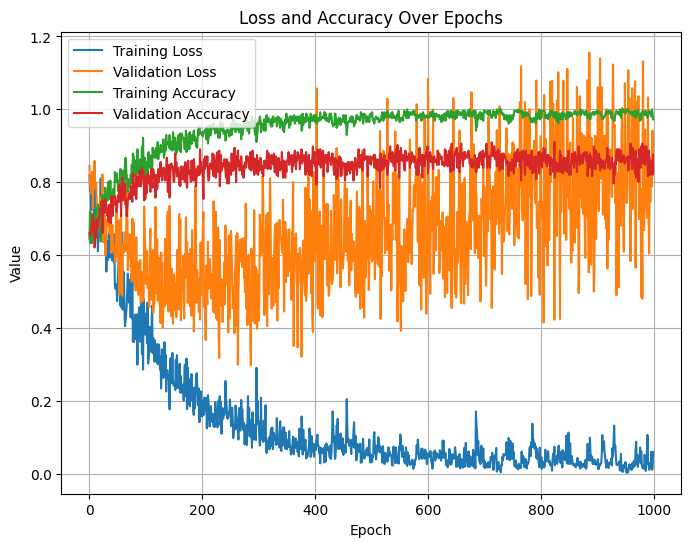

In [33]:
plt.figure(figsize=(8, 6))

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.title('Loss and Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


# Get prediction set

In [34]:
predict = model.predict_generator(validation_generator, steps = np.ceil(265/batch_size))

C:\Users\Farzad\AppData\Local\Temp\ipykernel_3000\869303907.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(validation_generator, steps = np.ceil(265/batch_size))


# Add prediction to the data frame

In [35]:
# Assuming you have 'validate_df' DataFrame containing validation data

# Get the number of samples in the validation set
num_samples = len(validate_df)

# Generate predictions using the model
predict = model.predict_generator(validation_generator, steps=np.ceil(num_samples / batch_size))

# Convert the predicted probabilities to class labels
predicted_labels = np.argmax(predict, axis=-1)

# Create a dictionary to map class indices to class labels
label_map = dict((v, k) for k, v in train_generator.class_indices.items())

# Convert class indices to class labels
predicted_class_labels = [label_map[i] for i in predicted_labels]

# Add the predicted class labels to the DataFrame
validate_df['predicted'] = predicted_class_labels

# The 'validate_df' DataFrame now contains both the original class labels and predicted labels


C:\Users\Farzad\AppData\Local\Temp\ipykernel_3000\686523774.py:7: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(validation_generator, steps=np.ceil(num_samples / batch_size))


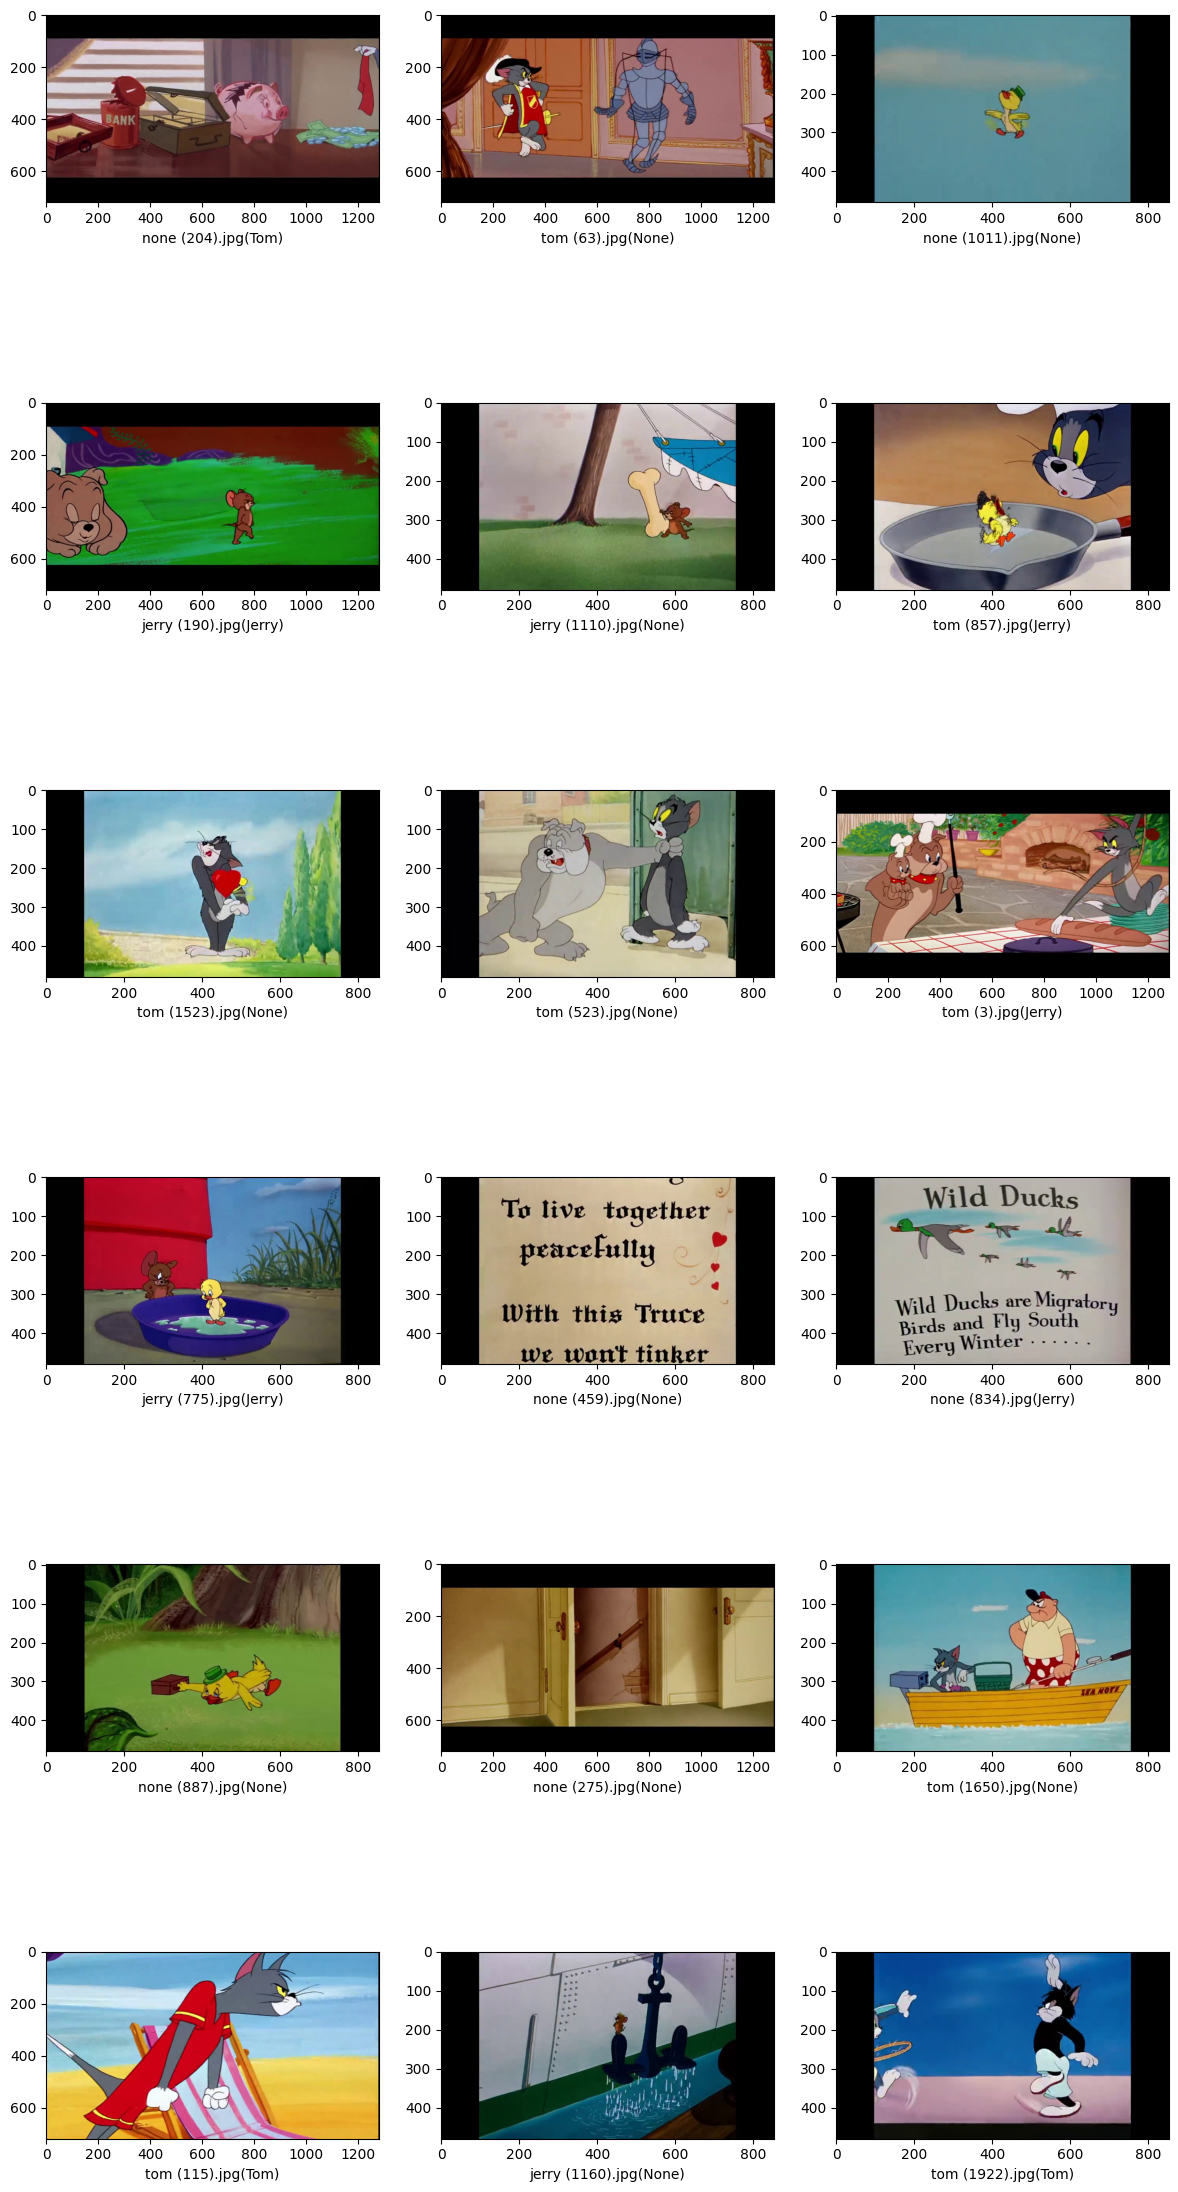

In [36]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img

sample_test = validate_df.head(18)

plt.figure(figsize=(12, 24))

for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['predicted']
    img = load_img("./images/train/" + filename)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )

plt.tight_layout()
plt.show()


# Do the same training using callbacks and early stopping

In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define the parameters

In [23]:
checkpoint = ModelCheckpoint("tom_vs_jerry_Checkpoint.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', # value being monitored for improvement
                          min_delta = 0, #Abs value and is the min change required before we stop
                          patience = 10, #Number of epochs we wait before stopping 
                          verbose = 1,
                          restore_best_weights = True) #keeps the best weigths once stopped

# Reducing learning rate on plateu

In [24]:
from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3, verbose = 1, min_delta = 0.0001)
callbacks = [earlystop, checkpoint, reduce_lr]


In [25]:
epochs = 1000

history = model.fit(
    train_generator, 
    callbacks = callbacks,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = 256//batch_size,
    steps_per_epoch = 256//batch_size,
)

Epoch 1/1000
8/8 [==============================] - ETA: 0s - loss: 1.3870 - accuracy: 0.2773
Epoch 1: val_loss improved from inf to 1.33899, saving model to tom_vs_jerry_Checkpoint.h5
8/8 [==============================] - 25s 939ms/step - loss: 1.3870 - accuracy: 0.2773 - val_loss: 1.3390 - val_accuracy: 0.4141 - lr: 5.0000e-04
Epoch 2/1000
8/8 [==============================] - ETA: 0s - loss: 1.3685 - accuracy: 0.3438
Epoch 2: val_loss did not improve from 1.33899
8/8 [==============================] - 6s 839ms/step - loss: 1.3685 - accuracy: 0.3438 - val_loss: 1.3503 - val_accuracy: 0.3242 - lr: 5.0000e-04
Epoch 3/1000
8/8 [==============================] - ETA: 0s - loss: 1.3797 - accuracy: 0.3150
Epoch 3: val_loss did not improve from 1.33899
8/8 [==============================] - 6s 816ms/step - loss: 1.3797 - accuracy: 0.3150 - val_loss: 1.3676 - val_accuracy: 0.3555 - lr: 5.0000e-04
Epoch 4/1000
8/8 [==============================] - ETA: 0s - loss: 1.3738 - accuracy: 0.3125


8/8 [==============================] - ETA: 0s - loss: 1.3169 - accuracy: 0.3583
Epoch 27: val_loss did not improve from 1.30600
8/8 [==============================] - 4s 476ms/step - loss: 1.3169 - accuracy: 0.3583 - val_loss: 1.3470 - val_accuracy: 0.3398 - lr: 8.0000e-07
Epoch 28/1000
8/8 [==============================] - ETA: 0s - loss: 1.3208 - accuracy: 0.3945
Epoch 28: val_loss did not improve from 1.30600

Epoch 28: ReduceLROnPlateau reducing learning rate to 1.6000001323845936e-07.
8/8 [==============================] - 4s 482ms/step - loss: 1.3208 - accuracy: 0.3945 - val_loss: 1.3296 - val_accuracy: 0.3555 - lr: 8.0000e-07
Epoch 29/1000
8/8 [==============================] - ETA: 0s - loss: 1.3122 - accuracy: 0.3867
Epoch 29: val_loss did not improve from 1.30600
8/8 [==============================] - 4s 504ms/step - loss: 1.3122 - accuracy: 0.3867 - val_loss: 1.3328 - val_accuracy: 0.3594 - lr: 1.6000e-07
Epoch 30/1000
8/8 [==============================] - ETA: 0s - loss: